# Loading word embeddings

In [4]:
import io
import numpy as np
import pandas as pd

In [49]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

# en-es.0-5000.txt     en-ru.0-5000.txt     fr-es.0-5000.txt     pt-de.0-5000.txt
# bn-en.5000-6500.txt               en-es.5000-6500.txt

def load_dict(dict_path="data/crosslingual/dictionaries/en-es.0-5000.txt"):
    
    return pd.read_csv(dict_path, names=["src", "tgt"], delim_whitespace=True)


def multi_key_dict(words, dict_):
    out = []
    for word in words:
        if word in dict_:
            out.append(dict_[word])
    return np.asarray(out)



In [50]:
en_es_dict = load_dict()
en_zh_dict = load_dict("data/crosslingual/dictionaries/en-zh.0-5000.txt")

In [52]:
en_es_dict

,src,tgt
0,the,el
1,the,las
2,the,los
3,the,la
4,and,y
...,...,...
11972,unions,sindicatos
11973,efficient,eficiente
11974,efficient,eficaz
11975,efficient,eficientes


In [59]:
src_path = 'data/wiki.en.vec'
tgt_path = 'data/wiki.es.vec'
tgt_path2 = 'data/wiki.zh.vec'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)
tgt_embeddings2, tgt_id2word2, tgt_word2id2 = load_vec(tgt_path2, nmax)

In [60]:
src, tgt, tgt2, = en_es_dict["src"].values, en_es_dict["tgt"].values, en_zh_dict["tgt"].values

In [61]:
src_ids = multi_key_dict(src, src_word2id)
tgt_ids = multi_key_dict(tgt, tgt_word2id)
tgt_ids2 = multi_key_dict(tgt2, tgt_word2id2)

In [62]:
tgt_ids.shape, src_ids.shape, tgt_ids2.shape

((11374,), (11977,), (8225,))

In [63]:
X , Y, Z = src_embeddings[src_ids, :], tgt_embeddings[tgt_ids,:], tgt_embeddings2[tgt_ids2,:]
X.shape, Y.shape, Z.shape

((11977, 300), (11374, 300), (8225, 300))

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'english')

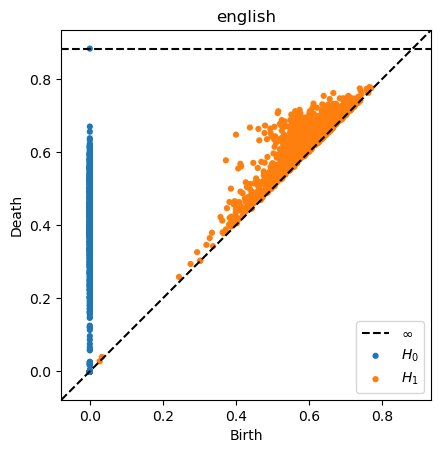

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips

rips = Rips()
data = X[:2000,:]
diagrams = rips.fit_transform(data, metric="cosine")
rips.plot(diagrams)
plt.title("english")

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'spanish')

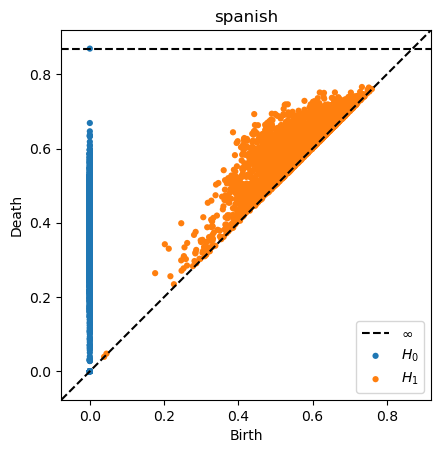

In [80]:
rips = Rips()
data = Y[:2000,:]
diagrams = rips.fit_transform(data, metric="cosine")
rips.plot(diagrams)
plt.title("spanish")

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Text(0.5, 1.0, 'mandarin')

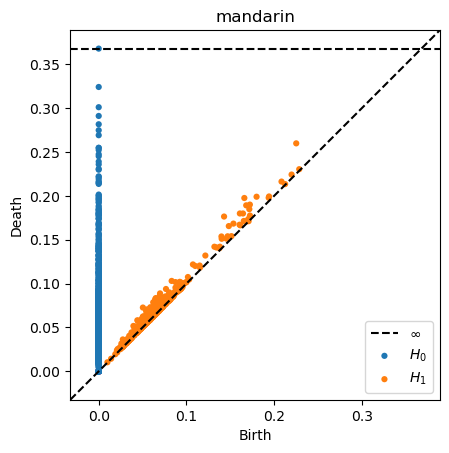

In [81]:
rips = Rips()
data = Z[:2000,:]
diagrams = rips.fit_transform(data, metric="cosine")
rips.plot(diagrams)
plt.title("mandarin")

# Get nearest neighbors

In [4]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [5]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [6]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6201 - gato
0.5380 - perro
0.4922 - gorila
0.4809 - mapache
0.4751 - conejo


# Visualize multilingual embeddings

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.07


In [8]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

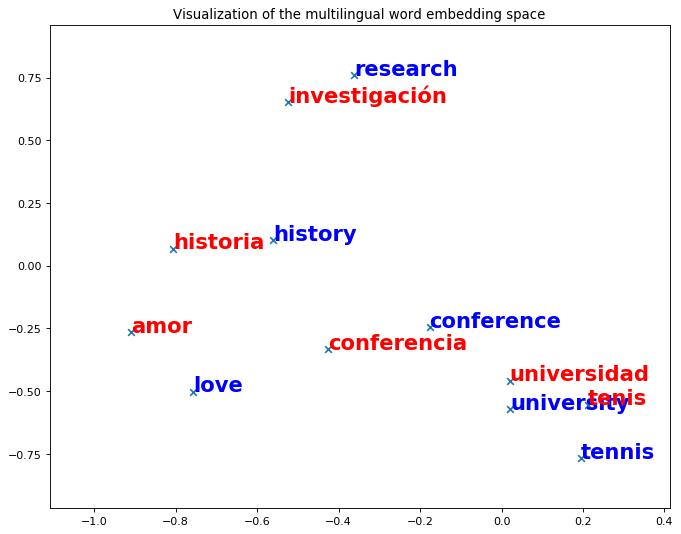

In [9]:
# get 5 random input words
src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)